<a href="https://colab.research.google.com/github/sachinthadilshann/pytorch_youtube_course_by_DanielBourke/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with PyTorch

## 1. Make classification data and get it ready

In [44]:
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np
import torch

n_samples = 1000

X , y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [45]:
len(X) , len(y)

(1000, 1000)

In [46]:
#y

In [47]:
circles = pd.DataFrame({"X1":X[:,0],
                       "X2":X[:,1],
                       "label":y})

In [48]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


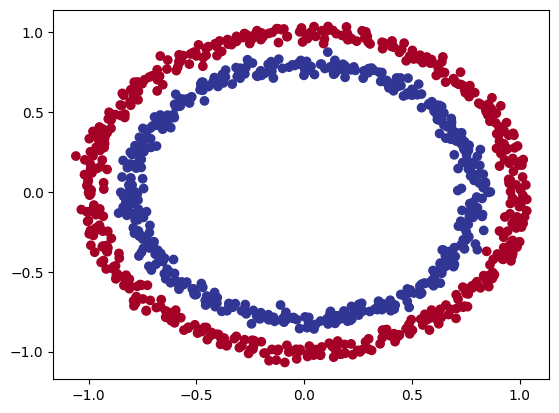

In [49]:
import matplotlib.pyplot as plt


plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1. Chech input and output shape

In [50]:
X.shape , y.shape

((1000, 2), (1000,))

In [51]:
X_sample = X[0]
y_sample = y[0]

print(f"Sample input features: {X_sample} and target: {y_sample}")
print(f"Input shape: {X_sample.shape} and target shape: {y_sample.shape}")

Sample input features: [0.75424625 0.23148074] and target: 1
Input shape: (2,) and target shape: ()


## 1.2 Turn data into tensor

In [52]:
type(X)

numpy.ndarray

In [53]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [54]:
type(X)

torch.Tensor

In [55]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,random_state=42)


In [57]:
len(X_train) , len(X_test)


(800, 200)

In [58]:
len(y_train),len(y_test)

(800, 200)

## Building Model

In [59]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [60]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [61]:
X_train.shape


torch.Size([800, 2])

In [62]:
y_train[:1]

tensor([1.])

In [63]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

    self.two_linear = nn.Sequential(
        self.layer_1,
        self.layer_2
    )

  def forward(self,x):
    return self.layer_2(self.layer_1(x))  # x -> layer 1 -> layer 2 -> output
    return self.two_linear(x)


model_0 = CircleModelV0().to(device)
model_0





CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [64]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [65]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [66]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3131],
        [-0.3428],
        [-0.3252],
        [-0.3093],
        [-0.4676],
        [-0.4846],
        [-0.4551],
        [-0.4887],
        [-0.3192],
        [-0.3463]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


###2.1 Setup loss function and optimizer

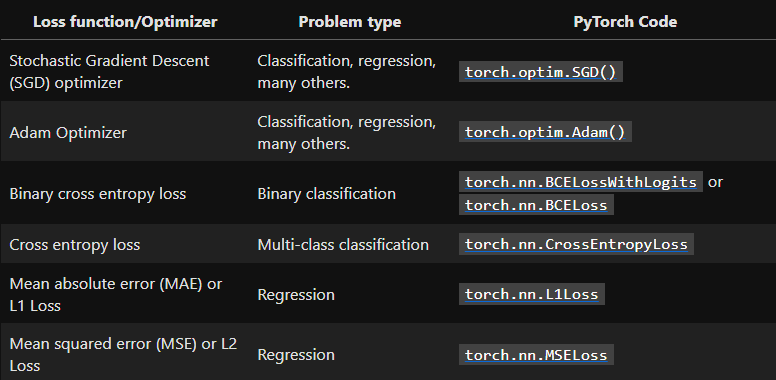

In [67]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

In [68]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## Train Model

1. Forward pass
2. Calculate loss
3. Zero gradients
4. Perform backpropagation on the loss
5. Step the optimizer

### 3.1 Going from raw logits -> prediction probabilities -> predicition labels

In [69]:
model_0.eval()
with torch.inference_mode():
  y_logit = model_0(X_test.to(device))[:5]
y_logit

tensor([[-0.3131],
        [-0.3428],
        [-0.3252],
        [-0.3093],
        [-0.4676]])

In [70]:
y_pred_prob = torch.sigmoid(y_logit)
y_pred_prob

tensor([[0.4224],
        [0.4151],
        [0.4194],
        [0.4233],
        [0.3852]])

In [71]:
y_preds = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

## 3.2 Building a training and testing loop

In [72]:
epochs =100

X_train,y_train = X_train.to(device),y_train.to(device)
x_test,y_test = X_test.to(device),y_test.to(device)

for epochs in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss = loss_fn(torch.sigmoid(y_logits),
  #               y_train)

  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)



  if epochs % 10 == 0:
    print(f"Epoch: {epochs} | Loss: {loss:.5f} | Acc: {acc:.5f} | Test loss: {test_loss:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71257 | Acc: 50.00000 | Test loss: 0.71% | Test Acc: 50.00%
Epoch: 10 | Loss: 0.69896 | Acc: 50.00000 | Test loss: 0.70% | Test Acc: 50.00%
Epoch: 20 | Loss: 0.69483 | Acc: 50.00000 | Test loss: 0.70% | Test Acc: 50.00%
Epoch: 30 | Loss: 0.69359 | Acc: 45.62500 | Test loss: 0.70% | Test Acc: 42.00%
Epoch: 40 | Loss: 0.69322 | Acc: 48.87500 | Test loss: 0.70% | Test Acc: 46.00%
Epoch: 50 | Loss: 0.69310 | Acc: 49.75000 | Test loss: 0.70% | Test Acc: 46.00%
Epoch: 60 | Loss: 0.69306 | Acc: 50.50000 | Test loss: 0.70% | Test Acc: 45.50%
Epoch: 70 | Loss: 0.69304 | Acc: 50.75000 | Test loss: 0.70% | Test Acc: 46.50%
Epoch: 80 | Loss: 0.69303 | Acc: 50.50000 | Test loss: 0.70% | Test Acc: 45.50%
Epoch: 90 | Loss: 0.69302 | Acc: 50.62500 | Test loss: 0.70% | Test Acc: 46.00%


## 4. Make preditions and Evaluate model

In [73]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_function.py already exists")

else :
  request = requests.get("https://raw.githubusercontent.com/sachinthadilshann/pytorch_youtube_course_by_DanielBourke/refs/heads/main/helper_function.py")
  with open("helper_function.py","wb") as f:
    f.write(request.content)
    print("helper_function.py downloaded")




helper_function.py already exists


In [74]:
from helper_function import plot_decision_boundary,plot_predictions

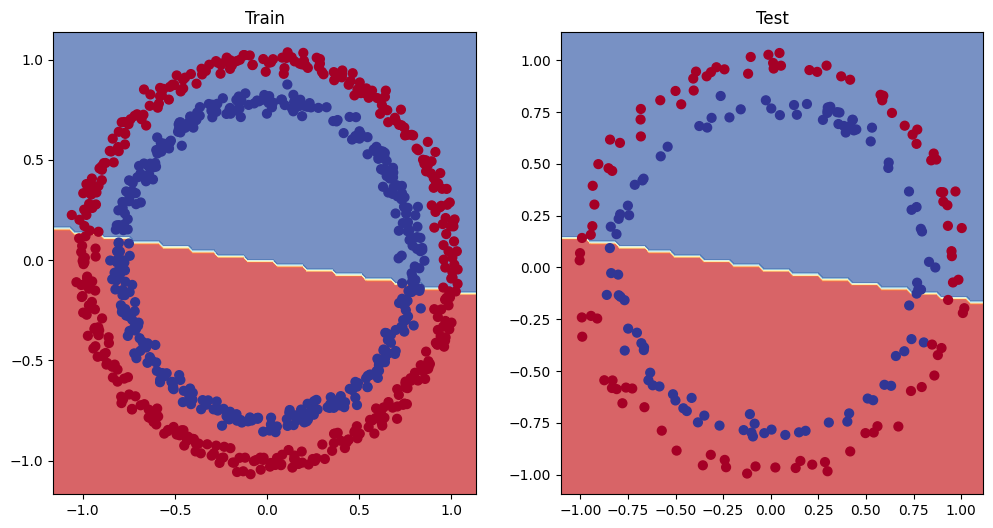

In [75]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improve Model

In [76]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1852, -0.4702],
                      [-0.0895, -0.2241],
                      [-0.5750, -0.0014],
                      [-0.4528, -0.1858],
                      [-0.3389,  0.1377]])),
             ('0.bias', tensor([-0.2148, -0.0657, -0.6771, -0.4800,  0.4249])),
             ('1.weight',
              tensor([[-0.3817,  0.3850, -0.2240,  0.2186,  0.1628]])),
             ('1.bias', tensor([-0.1720]))])

In [77]:
X_train[:1]

tensor([[ 0.6579, -0.4651]])

In [78]:
class CirculeModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10) #x_train have two features
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

    def forward(self,x):
      return self.layer_3(self.layer_2(self.layer_1(x)))


In [79]:
model_1 = CirculeModelV1().to(device)
model_1

CirculeModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [80]:
class CirculeModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10) #x_train have two features
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


In [81]:
model_1 = CirculeModelV1().to(device)
model_1

CirculeModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [82]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test)

  if epoch % 100 == 0:
    print(f"Epoch:{epochs} | LOSS:{loss:.5f} |Acc:{acc:.2f}  | Test Loss:{test_loss:.2f} Test Acc:{test_acc:.2f} " )




Epoch:1000 | LOSS:0.71472 |Acc:50.00  | Test Loss:0.71 Test Acc:100.00 
Epoch:1000 | LOSS:0.69305 |Acc:49.75  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.25  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.12  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.12  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.12  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.00  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.00  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.00  | Test Loss:0.69 Test Acc:100.00 
Epoch:1000 | LOSS:0.69298 |Acc:51.00  | Test Loss:0.69 Test Acc:100.00 


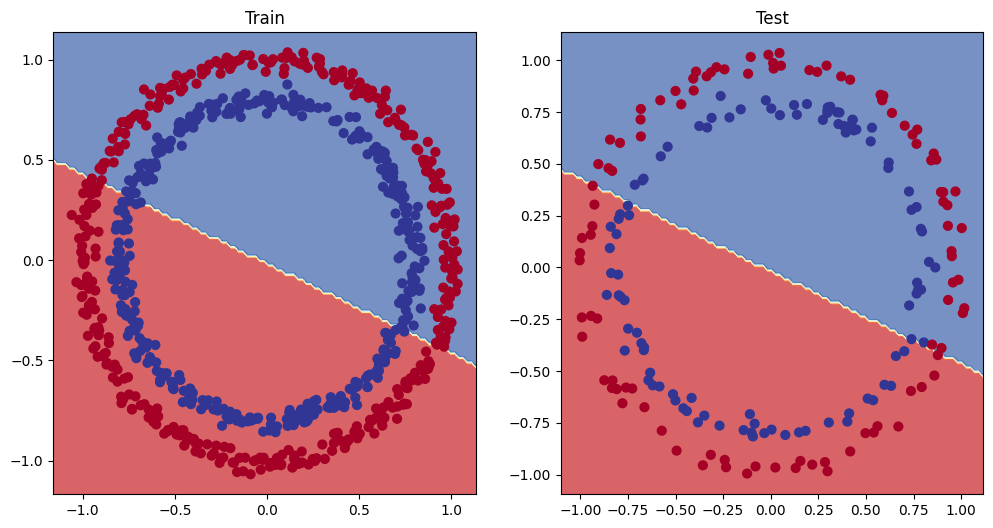

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fix a strainght line

In [90]:
weight =0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [91]:
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]



print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


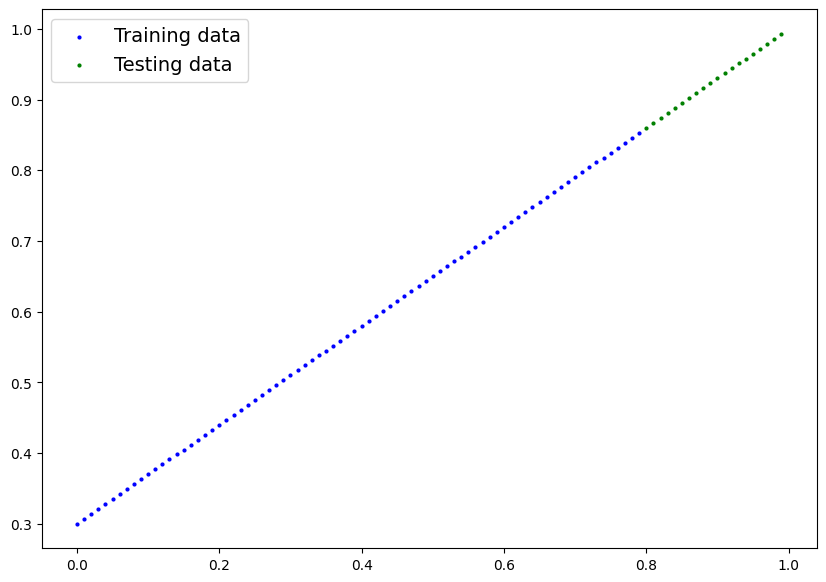

In [92]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [93]:
X_train_regression[:10],y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2 Adjuisting model_1 to fit a Straight line

In [95]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [96]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.1)

In [86]:
epochs = =1000

X_train_regression ,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range epochs():
  y_pred = model_2